In [8]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [2]:
#path = '../Data/car_dataset_sample/'
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'

#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  161526
Image_labels: 161526


In [9]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  290400
Image_labels: 290400


In [10]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211012_NI_071_18_WH_A_P_01_034.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
1,C_211012_NI_071_18_WH_A_T_03_022.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
2,C_211012_NI_071_18_WH_A_P_01_064.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
3,C_211012_NI_071_18_WH_A_P_01_051.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
4,C_211012_NI_071_18_WH_A_P_01_058.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
...,...,...,...
290395,C_211129_JE_087_21_WH_A_T_03_004.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290396,C_211129_JE_087_21_WH_A_T_03_010.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290397,C_211129_JE_087_21_WH_A_P_01_057.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290398,C_211129_JE_087_21_WH_A_P_01_011.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021


In [5]:
first = le.inverse_transform([100])
first

array(['닛산/알티마/2018'], dtype='<U18')

In [4]:
train['label'].value_counts()

벤츠/E-Class/2017       3566
현대/코나/2018            2755
기아/모닝/2017            2721
기아/K3/2019            2563
기아/스포티지/2018          2471
                      ... 
지프/랭글러/2021             91
쉐보레/볼트EV/2017           90
BMW/X3/2020             89
미니/Countryman/2021      79
지프/랭글러/2018             70
Name: label, Length: 370, dtype: int64

In [5]:
train['label'].value_counts().loc[lambda x : x < 900]

폭스바겐/골프/2017          864
기아/K5/2021            855
기아/스포티지/2020          855
현대/i30/2017           855
현대/엑센트/2017           854
                     ... 
지프/랭글러/2021            91
쉐보레/볼트EV/2017          90
BMW/X3/2020            89
미니/Countryman/2021     79
지프/랭글러/2018            70
Name: label, Length: 236, dtype: int64

In [11]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

# for i, label in enumerate(train['label']):
#     #print(label)
#     if any(j in label for j in low_data) :
#         train.drop(i)
# train['label'].value_counts()

Index(['BMW/3시리즈/2019', 'BMW/3시리즈/2020', 'BMW/5시리즈/2019', 'BMW/5시리즈/2020',
       'BMW/5시리즈/2021', 'BMW/7시리즈/2017', 'BMW/7시리즈/2018', 'BMW/7시리즈/2019',
       'BMW/7시리즈/2020', 'BMW/X3/2017',
       ...
       '현대/코나/2021', '현대/투싼/2021', '현대/포터2/2018', '현대/포터2/2019', '현대/포터2/2020',
       '현대/포터2/2021', '혼다/CR-V/2017', '혼다/CR-V/2021', '혼다/어코드/2017',
       '혼다/어코드/2021'],
      dtype='object', length=236)

In [12]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
...,...,...,...
206641,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206642,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206643,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206644,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020


In [6]:
train['label'].value_counts()

벤츠/E-Class/2017    3566
현대/코나/2018         2755
기아/모닝/2017         2721
기아/K3/2019         2563
기아/스포티지/2018       2471
                   ... 
기아/니로/2018          940
쉐보레/스파크/2020        938
현대/스타렉스/2020        937
현대/팰리세이드/2020       935
기아/니로/2019          923
Name: label, Length: 134, dtype: int64

In [7]:
print(len(train.label))

206646


In [7]:
train.label.nunique()

134

In [13]:
label_value = train['label'].values
label_value

array(['쌍용/티볼리/2018', '쌍용/티볼리/2018', '쌍용/티볼리/2018', ...,
       '벤츠/E-Class/2020', '벤츠/E-Class/2020', '벤츠/E-Class/2020'],
      dtype=object)

In [14]:
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
...,...,...,...
206641,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206642,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206643,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206644,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69


In [6]:
dist.destroy_process_group()

NameError: name 'dist' is not defined

In [15]:
project_name = 'preprocessed_ef_ns_03_01'
user = 'hojunking'
run_name = 'preprocessed_ef_ns_03_01'

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /home/hojun/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Training start with epoch 40 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
epoch 0 loss: 0.9364: 100%|███████████████| 11947/11947 [50:09<00:00,  3.97it/s]


train accuracy = 0.47258
[[1423  453  193 ...    0    0    4]
 [ 390 1717   61 ...    0    0    3]
 [ 220   55 1435 ...    1    1    0]
 ...
 [   2    7    2 ... 1265  491    6]
 [   4    1    0 ...  592 1259    9]
 [   4    2    0 ...    2    0 2317]]


epoch 0 loss: 0.9915: 100%|█████████████████| 2584/2584 [05:10<00:00,  8.31it/s]


validation accuracy = 0.61072
[[234  17  10 ...   0   0   0]
 [ 47 148   2 ...   0   0   0]
 [ 27   7 334 ...   0   0   0]
 ...
 [  0   0   0 ... 107  43   0]
 [  1   0   0 ...  26 172   0]
 [  0   0   0 ...   0   0 211]]


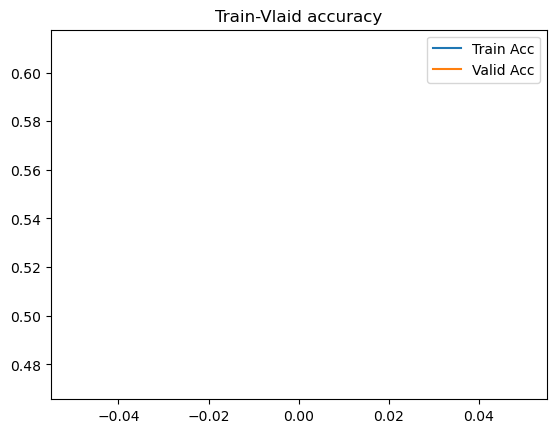

epoch 1 loss: 0.5876: 100%|███████████████| 11947/11947 [48:43<00:00,  4.09it/s]


train accuracy = 0.72896
[[2381  234   88 ...    0    0    0]
 [ 220 2483   14 ...    0    0    0]
 [ 108   15 2278 ...    1    0    0]
 ...
 [   0    0    0 ... 2175  313    0]
 [   0    0    0 ...  445 2035    0]
 [   0    0    0 ...    0    0 2740]]


epoch 1 loss: 0.7475: 100%|█████████████████| 2584/2584 [05:08<00:00,  8.37it/s]


validation accuracy = 0.71735
[[231  30   5 ...   0   0   0]
 [ 13 184   1 ...   0   0   0]
 [ 15   5 341 ...   0   0   0]
 ...
 [  0   0   0 ... 135  35   0]
 [  0   0   0 ...  18 185   0]
 [  0   0   0 ...   0   0 209]]


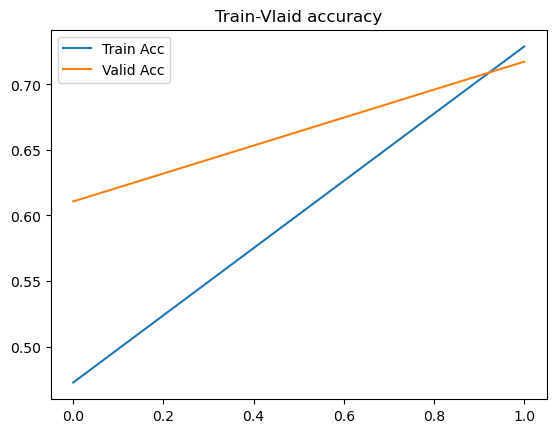

epoch 2 loss: 0.3841: 100%|███████████████| 11947/11947 [48:48<00:00,  4.08it/s]


train accuracy = 0.82993
[[2578  148   53 ...    0    0    0]
 [ 145 2634    4 ...    0    0    0]
 [  64    7 2488 ...    0    0    0]
 ...
 [   0    0    0 ... 2532  164    1]
 [   0    0    0 ...  222 2442    0]
 [   1    1    0 ...    1    0 2782]]


epoch 2 loss: 0.6537: 100%|█████████████████| 2584/2584 [05:10<00:00,  8.32it/s]


validation accuracy = 0.76571
[[243  12   5 ...   0   1   0]
 [ 22 176   1 ...   0   0   0]
 [ 10   2 358 ...   0   0   0]
 ...
 [  0   0   0 ... 152  29   0]
 [  0   0   0 ...  12 199   0]
 [  0   0   0 ...   0   0 207]]


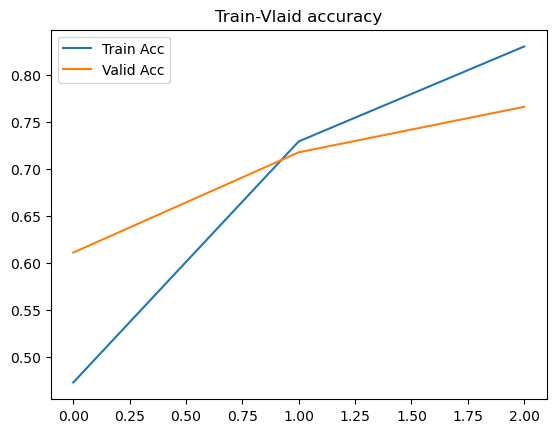

epoch 3 loss: 0.2660: 100%|███████████████| 11947/11947 [49:12<00:00,  4.05it/s]


train accuracy = 0.88397
[[2687   76   35 ...    0    0    0]
 [  75 2737    4 ...    0    0    0]
 [  42    6 2599 ...    0    0    0]
 ...
 [   0    0    0 ... 2685   79    0]
 [   0    0    0 ...   93 2646    0]
 [   0    0    1 ...    0    0 2814]]


epoch 3 loss: 0.6026: 100%|█████████████████| 2584/2584 [05:12<00:00,  8.27it/s]


validation accuracy = 0.79378
[[246  18   4 ...   0   0   0]
 [ 11 191   0 ...   0   0   0]
 [  4   2 356 ...   0   0   0]
 ...
 [  0   0   0 ... 174   6   0]
 [  0   1   0 ...  26 181   0]
 [  0   0   0 ...   0   0 220]]


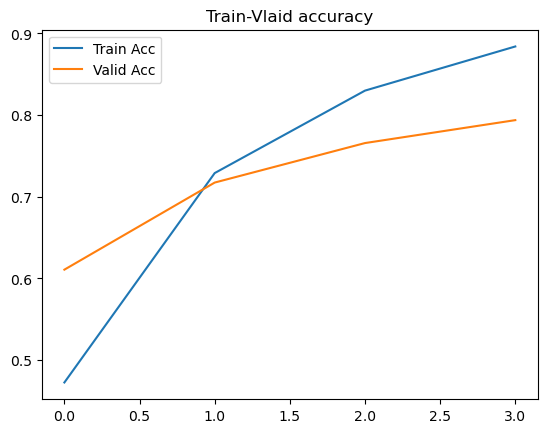

epoch 4 loss: 0.2025: 100%|███████████████| 11947/11947 [48:59<00:00,  4.06it/s]


train accuracy = 0.91514
[[2708   68   32 ...    0    0    0]
 [  62 2765    5 ...    0    0    0]
 [  18    1 2672 ...    0    0    0]
 ...
 [   0    0    0 ... 2735   60    0]
 [   1    1    0 ...   63 2719    0]
 [   0    0    0 ...    0    0 2821]]


epoch 4 loss: 0.5667: 100%|█████████████████| 2584/2584 [05:09<00:00,  8.34it/s]


validation accuracy = 0.81757
[[258  10   2 ...   0   0   0]
 [ 23 179   0 ...   0   0   0]
 [  8   3 370 ...   0   0   0]
 ...
 [  0   0   0 ... 172  12   0]
 [  0   0   0 ...  11 204   0]
 [  0   0   0 ...   0   0 214]]


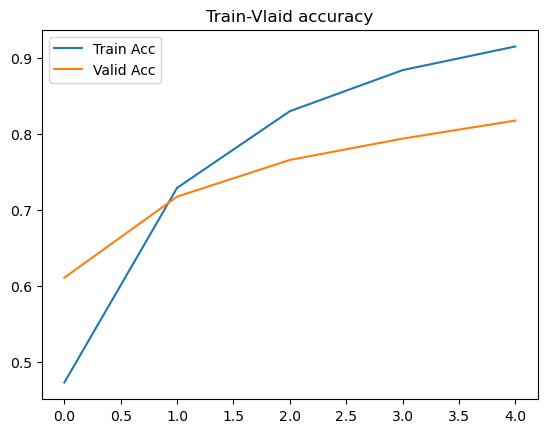

epoch 5 loss: 0.1679: 100%|███████████████| 11947/11947 [48:55<00:00,  4.07it/s]


train accuracy = 0.93469
[[2749   41   23 ...    0    0    0]
 [  39 2779    2 ...    0    0    0]
 [  27    3 2719 ...    0    0    0]
 ...
 [   0    0    0 ... 2766   45    0]
 [   0    0    0 ...   42 2750    0]
 [   0    0    0 ...    0    0 2832]]


epoch 5 loss: 0.5757: 100%|█████████████████| 2584/2584 [05:08<00:00,  8.37it/s]


validation accuracy = 0.82683
[[248  11   8 ...   0   0   0]
 [  4 197   1 ...   0   0   0]
 [  4   6 380 ...   0   0   0]
 ...
 [  0   0   0 ... 168  12   0]
 [  0   0   0 ...   9 209   0]
 [  0   0   0 ...   0   0 218]]


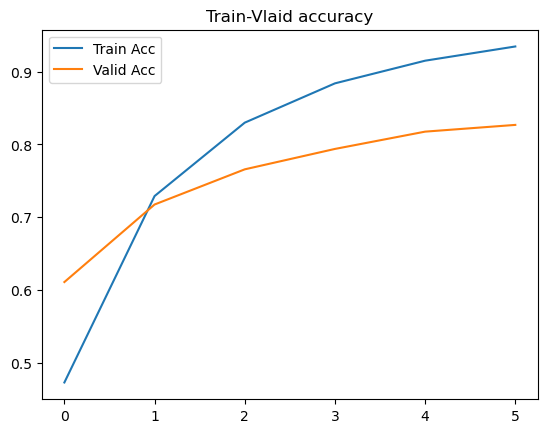

epoch 6 loss: 0.1333: 100%|███████████████| 11947/11947 [48:57<00:00,  4.07it/s]


train accuracy = 0.94739
[[2767   37   15 ...    0    0    1]
 [  36 2788    2 ...    0    0    0]
 [  22    2 2745 ...    1    0    0]
 ...
 [   0    0    0 ... 2780   33    0]
 [   0    0    0 ...   37 2778    0]
 [   0    0    0 ...    0    0 2824]]


epoch 6 loss: 0.5866: 100%|█████████████████| 2584/2584 [05:09<00:00,  8.34it/s]


validation accuracy = 0.83233
[[255   8   5 ...   0   0   0]
 [ 16 185   1 ...   0   0   0]
 [  4   2 385 ...   0   0   0]
 ...
 [  0   0   0 ... 171  12   0]
 [  0   0   0 ...   6 214   0]
 [  0   0   0 ...   0   0 216]]


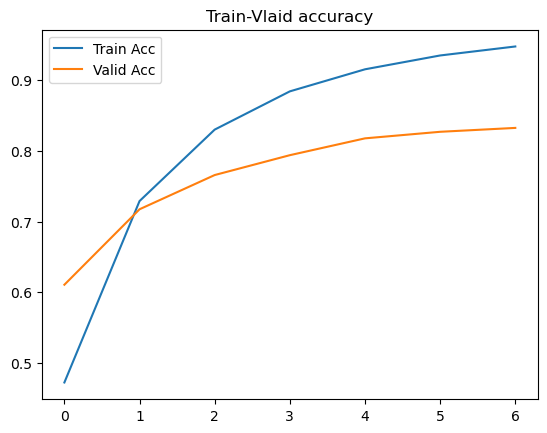

epoch 7 loss: 0.1170: 100%|███████████████| 11947/11947 [48:57<00:00,  4.07it/s]


train accuracy = 0.95564
[[2787   31   13 ...    0    0    0]
 [  34 2801    3 ...    0    0    0]
 [  15    0 2756 ...    1    0    0]
 ...
 [   0    0    0 ... 2792   28    0]
 [   0    0    1 ...   28 2789    0]
 [   0    0    0 ...    0    0 2836]]


epoch 7 loss: 0.5765: 100%|█████████████████| 2584/2584 [05:09<00:00,  8.34it/s]


validation accuracy = 0.84101
[[252  16   3 ...   0   0   0]
 [  7 193   0 ...   0   0   0]
 [  5   1 361 ...   0   0   0]
 ...
 [  0   0   0 ... 166  12   0]
 [  0   0   0 ...  12 196   0]
 [  0   0   0 ...   0   0 214]]


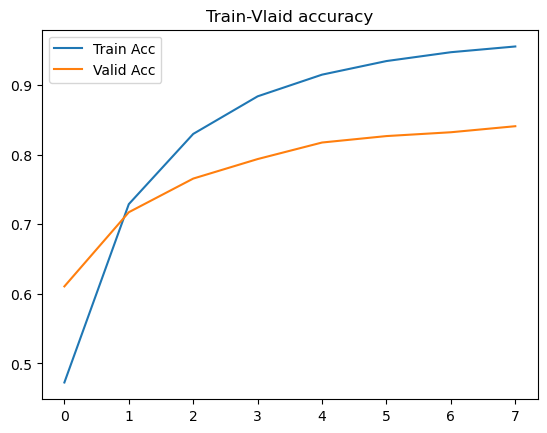

epoch 8 loss: 0.1054: 100%|███████████████| 11947/11947 [49:10<00:00,  4.05it/s]


train accuracy = 0.96260
[[2799   31    9 ...    0    0    0]
 [  24 2808    2 ...    0    0    0]
 [  11    0 2774 ...    0    0    0]
 ...
 [   0    0    0 ... 2798   22    0]
 [   0    0    0 ...   20 2798    0]
 [   0    0    0 ...    0    0 2832]]


epoch 8 loss: 0.6035: 100%|█████████████████| 2584/2584 [05:08<00:00,  8.38it/s]


validation accuracy = 0.84128
[[247  21   2 ...   0   0   0]
 [  4 198   0 ...   0   0   0]
 [  7   7 362 ...   0   0   0]
 ...
 [  0   0   0 ... 178   4   0]
 [  0   0   0 ...   7 209   0]
 [  0   0   0 ...   0   0 214]]


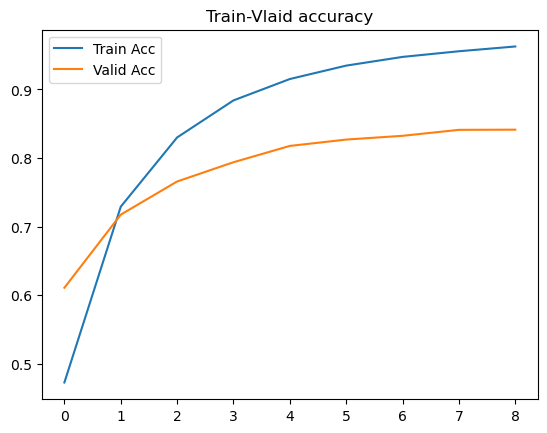

epoch 9 loss: 0.0923: 100%|███████████████| 11947/11947 [49:14<00:00,  4.04it/s]


train accuracy = 0.96742
[[2797   28    5 ...    0    0    0]
 [  27 2814    1 ...    0    1    0]
 [   8    4 2782 ...    0    1    0]
 ...
 [   0    0    0 ... 2809   22    0]
 [   0    0    0 ...   29 2790    0]
 [   0    0    0 ...    0    0 2839]]


epoch 9 loss: 0.6155: 100%|█████████████████| 2584/2584 [05:09<00:00,  8.35it/s]


validation accuracy = 0.84479
[[248  18   2 ...   0   0   0]
 [ 10 189   0 ...   0   0   0]
 [  5   2 378 ...   0   0   0]
 ...
 [  0   0   0 ... 171  10   0]
 [  0   0   0 ...   6 209   0]
 [  0   0   0 ...   0   0 219]]


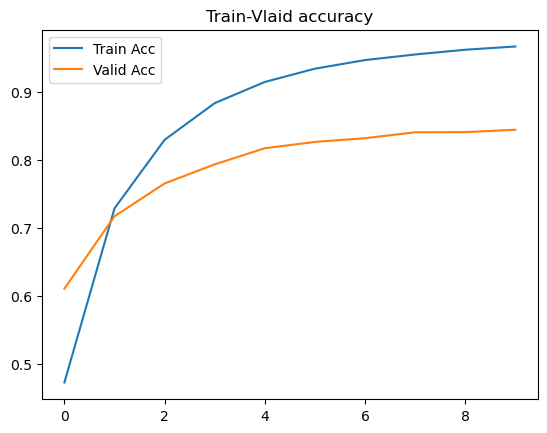

epoch 10 loss: 0.0754: 100%|██████████████| 11947/11947 [49:17<00:00,  4.04it/s]


train accuracy = 0.97109
[[2804   24    5 ...    0    0    1]
 [  19 2815    1 ...    0    0    0]
 [   8    0 2806 ...    0    0    0]
 ...
 [   0    0    0 ... 2803   26    0]
 [   0    0    0 ...   23 2799    0]
 [   0    0    0 ...    0    0 2838]]


epoch 10 loss: 0.6062: 100%|████████████████| 2584/2584 [05:08<00:00,  8.37it/s]


validation accuracy = 0.84907
[[258   6   3 ...   0   0   0]
 [ 14 186   0 ...   0   0   0]
 [  7   0 366 ...   0   0   0]
 ...
 [  0   0   0 ... 156  27   0]
 [  0   1   0 ...   5 211   0]
 [  0   0   0 ...   0   0 216]]


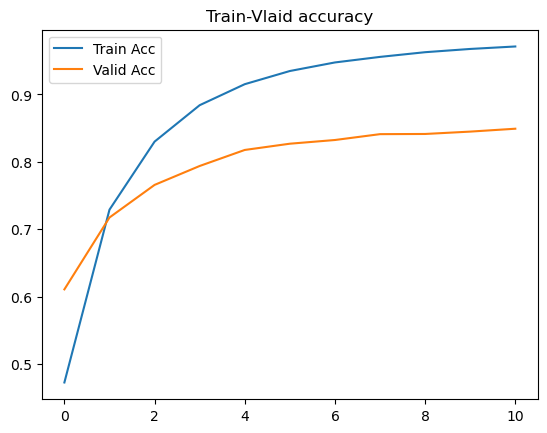

epoch 11 loss: 0.0748: 100%|██████████████| 11947/11947 [49:10<00:00,  4.05it/s]


train accuracy = 0.97362
[[2811   13   11 ...    0    0    0]
 [  15 2821    3 ...    0    0    0]
 [   6    1 2795 ...    0    0    0]
 ...
 [   0    0    0 ... 2821   14    0]
 [   0    0    0 ...   14 2806    0]
 [   0    0    0 ...    0    0 2837]]


epoch 11 loss: 0.6181: 100%|████████████████| 2584/2584 [05:09<00:00,  8.36it/s]


validation accuracy = 0.85057
[[253  15   4 ...   0   0   0]
 [  6 195   0 ...   0   0   0]
 [  6   3 364 ...   0   0   0]
 ...
 [  0   0   0 ... 174   7   0]
 [  0   0   0 ...   7 209   0]
 [  0   0   0 ...   0   0 207]]


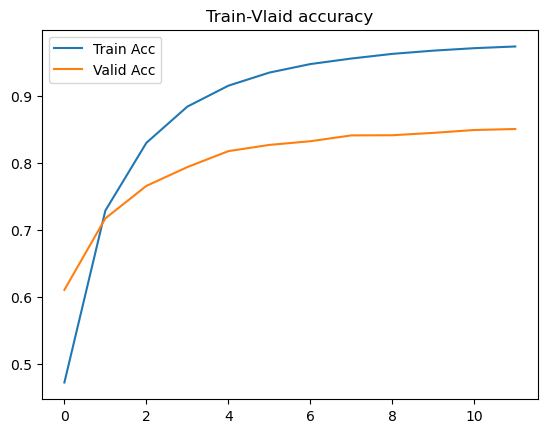

epoch 12 loss: 0.0671: 100%|██████████████| 11947/11947 [49:12<00:00,  4.05it/s]


train accuracy = 0.97612
[[2813   16    7 ...    0    0    0]
 [  20 2823    0 ...    0    0    0]
 [   8    2 2796 ...    0    0    0]
 ...
 [   0    0    0 ... 2814   15    0]
 [   1    0    0 ...   15 2822    0]
 [   0    0    0 ...    0    0 2840]]


epoch 12 loss: 0.6000: 100%|████████████████| 2584/2584 [05:09<00:00,  8.35it/s]


validation accuracy = 0.85650
[[241  25   2 ...   0   0   0]
 [  3 199   0 ...   0   0   0]
 [  2   3 369 ...   0   0   0]
 ...
 [  0   0   0 ... 166  12   0]
 [  0   0   0 ...  10 202   0]
 [  0   0   0 ...   0   0 217]]


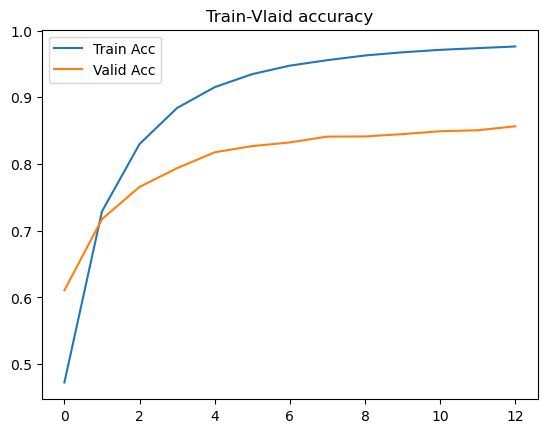

epoch 13 loss: 0.0636: 100%|██████████████| 11947/11947 [49:10<00:00,  4.05it/s]


train accuracy = 0.97833
[[2796   26   11 ...    0    0    0]
 [  19 2816    0 ...    0    1    0]
 [   9    1 2803 ...    0    0    0]
 ...
 [   0    0    0 ... 2831    7    0]
 [   0    0    0 ...    6 2822    0]
 [   0    0    0 ...    0    0 2844]]


epoch 13 loss: 0.6269: 100%|████████████████| 2584/2584 [05:10<00:00,  8.33it/s]


validation accuracy = 0.85478
[[254  11   3 ...   0   0   0]
 [  4 195   1 ...   0   0   0]
 [  1   0 368 ...   0   0   0]
 ...
 [  0   0   0 ... 170   8   0]
 [  0   0   0 ...   8 206   0]
 [  0   0   0 ...   0   0 214]]


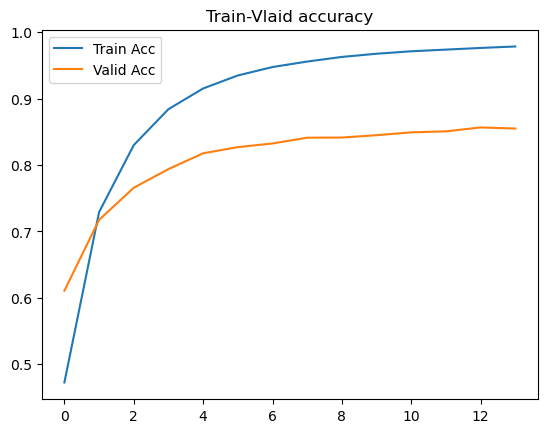

epoch 14 loss: 0.0558: 100%|██████████████| 11947/11947 [49:05<00:00,  4.06it/s]


train accuracy = 0.97976
[[2811   20   10 ...    0    0    0]
 [  21 2817    0 ...    0    0    0]
 [  10    0 2806 ...    0    0    0]
 ...
 [   0    0    0 ... 2828    8    0]
 [   0    0    0 ...   12 2824    0]
 [   0    0    0 ...    0    0 2843]]


epoch 14 loss: 0.6280: 100%|████████████████| 2584/2584 [05:13<00:00,  8.24it/s]


validation accuracy = 0.85800
[[256   8   4 ...   0   0   0]
 [  8 192   0 ...   0   0   0]
 [  3   1 379 ...   0   0   0]
 ...
 [  0   0   0 ... 177   4   0]
 [  0   0   0 ...   8 201   0]
 [  0   0   0 ...   0   0 217]]


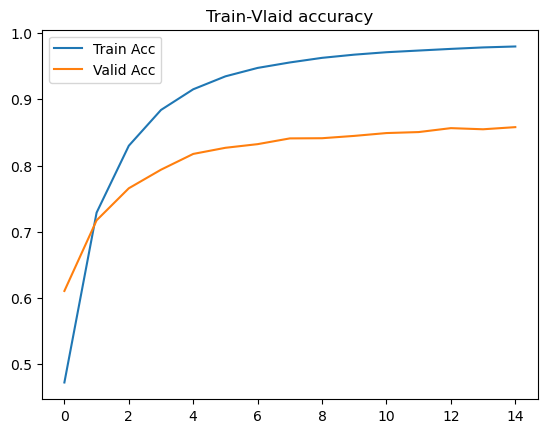

epoch 15 loss: 0.0566: 100%|██████████████| 11947/11947 [49:14<00:00,  4.04it/s]


train accuracy = 0.98151
[[2818   15    2 ...    0    0    0]
 [  16 2832    1 ...    0    0    0]
 [   3    1 2806 ...    0    0    0]
 ...
 [   0    0    0 ... 2828    8    0]
 [   0    0    0 ...   14 2820    0]
 [   0    0    0 ...    0    0 2841]]


epoch 15 loss: 0.6448: 100%|████████████████| 2584/2584 [05:09<00:00,  8.35it/s]


validation accuracy = 0.85848
[[260   5   4 ...   0   0   0]
 [ 10 188   0 ...   0   0   0]
 [  3   0 387 ...   0   0   0]
 ...
 [  0   0   0 ... 170   9   0]
 [  0   0   0 ...   9 206   0]
 [  0   0   0 ...   0   0 215]]


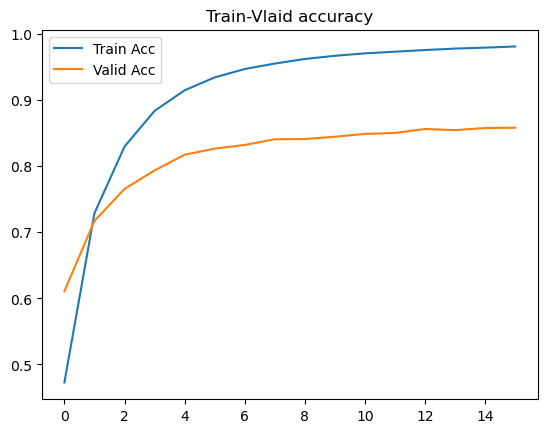

epoch 16 loss: 0.0504: 100%|██████████████| 11947/11947 [49:15<00:00,  4.04it/s]


train accuracy = 0.98251
[[2822   16    3 ...    0    0    0]
 [  14 2828    3 ...    0    0    0]
 [   9    3 2808 ...    0    0    0]
 ...
 [   0    0    0 ... 2824   11    0]
 [   0    0    0 ...   11 2822    0]
 [   0    0    0 ...    0    0 2840]]


epoch 16 loss: 0.6328: 100%|████████████████| 2584/2584 [05:10<00:00,  8.32it/s]


validation accuracy = 0.86080
[[256   7   4 ...   0   0   0]
 [ 12 189   1 ...   0   0   0]
 [  2   2 381 ...   0   0   0]
 ...
 [  0   0   0 ... 173   9   0]
 [  0   0   0 ...  12 209   0]
 [  0   0   0 ...   0   0 217]]


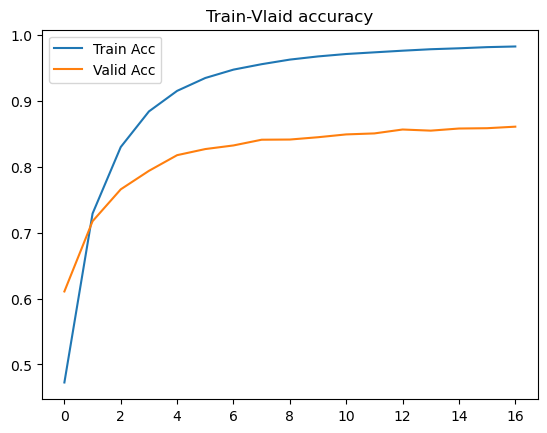

epoch 17 loss: 0.0457: 100%|██████████████| 11947/11947 [49:15<00:00,  4.04it/s]


train accuracy = 0.98355
[[2825   12    8 ...    0    0    0]
 [  12 2830    1 ...    0    0    0]
 [   6    0 2804 ...    0    1    0]
 ...
 [   0    0    0 ... 2826   14    0]
 [   0    0    0 ...   10 2824    0]
 [   0    0    0 ...    0    0 2843]]


epoch 17 loss: 0.6477: 100%|████████████████| 2584/2584 [05:09<00:00,  8.36it/s]


validation accuracy = 0.85867
[[258   3   3 ...   0   0   0]
 [  8 189   1 ...   0   0   0]
 [  3   1 372 ...   0   0   0]
 ...
 [  0   0   0 ... 162  12   0]
 [  0   0   0 ...  10 205   0]
 [  0   0   0 ...   0   0 216]]


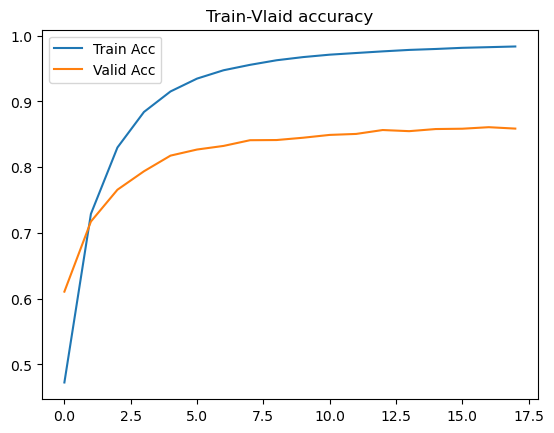

epoch 18 loss: 0.0424: 100%|██████████████| 11947/11947 [49:21<00:00,  4.03it/s]


train accuracy = 0.98441
[[2826   11    5 ...    0    0    0]
 [   8 2831    3 ...    0    1    0]
 [   7    1 2818 ...    1    0    0]
 ...
 [   0    0    0 ... 2830   12    0]
 [   0    0    0 ...   14 2827    0]
 [   0    0    0 ...    0    0 2843]]


epoch 18 loss: 0.6549: 100%|████████████████| 2584/2584 [05:11<00:00,  8.29it/s]


validation accuracy = 0.86150
[[260   7   2 ...   0   0   0]
 [  8 195   0 ...   0   0   0]
 [  3   3 382 ...   0   0   0]
 ...
 [  0   0   0 ... 163  13   0]
 [  0   0   0 ...   6 207   0]
 [  0   0   0 ...   0   0 218]]


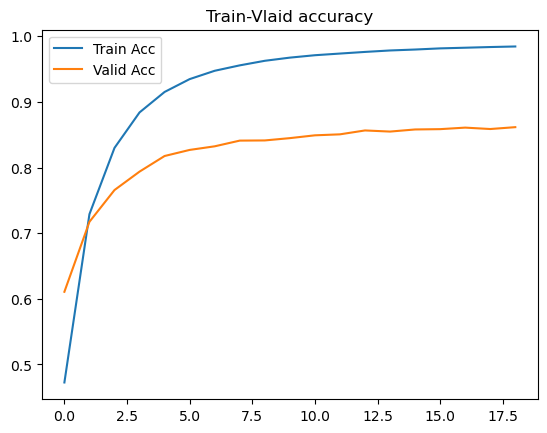

epoch 19 loss: 0.0364: 100%|██████████████| 11947/11947 [49:16<00:00,  4.04it/s]


train accuracy = 0.98521
[[2824   11    8 ...    0    0    0]
 [  13 2834    0 ...    0    0    0]
 [   3    1 2820 ...    0    0    0]
 ...
 [   0    0    0 ... 2831    9    0]
 [   0    0    0 ...    9 2826    0]
 [   0    0    0 ...    0    0 2847]]


epoch 19 loss: 0.6610: 100%|████████████████| 2584/2584 [05:09<00:00,  8.36it/s]


validation accuracy = 0.86221
[[254   9   5 ...   0   0   0]
 [  8 192   1 ...   0   0   0]
 [  5   2 382 ...   0   0   0]
 ...
 [  0   0   0 ... 169   9   0]
 [  0   0   0 ...   5 204   0]
 [  0   0   0 ...   0   0 215]]


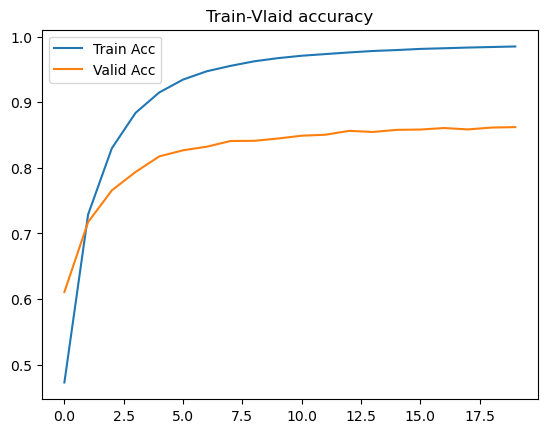

epoch 20 loss: 0.0357: 100%|██████████████| 11947/11947 [49:15<00:00,  4.04it/s]


train accuracy = 0.98584
[[2827   13    4 ...    0    0    0]
 [   7 2834    1 ...    0    0    0]
 [   7    0 2817 ...    0    0    0]
 ...
 [   0    0    0 ... 2826   10    0]
 [   0    0    0 ...    8 2820    0]
 [   0    0    0 ...    0    0 2845]]


epoch 30 loss: 0.0118:  41%|██████         | 4865/11947 [20:39<27:37,  4.27it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 30 loss: 0.0083:  59%|████████▊      | 7034/11947 [29:49<19:43,  4.15it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 30 loss: 0.0084:  90%|████████████▌ | 10767/11947 [45:36<04:44,  4.15it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

train accuracy = 0.99681
[[2848    2    1 ...    0    0    0]
 [   1 2851    0 ...    0    0    0]
 [   0    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    1    0]
 [   0    0    0 ...    4 2846    0]
 [   0    0    0 ...    0    0 2851]]


epoch 32 loss: 0.5804:  15%|██▌              | 384/2584 [00:47<04:05,  8.97it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 33 loss: 0.0109:  20%|██▉            | 2381/11947 [09:53<41:54,  3.80it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 33 loss: 0.0121:  49%|███████▎       | 5798/11947 [24:06<25:06,  4.08it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

train accuracy = 0.99682
[[2845    5    0 ...    0    0    0]
 [   4 2847    1 ...    0    0    0]
 [   0    0 2845 ...    0    0    0]
 ...
 [   0    0    0 ... 2850    1    0]
 [   0    0    0 ...    1 2850    0]
 [   0    0    0 ...    0    0 2851]]


epoch 33 loss: 0.6126:  33%|█████▌           | 846/2584 [01:42<03:41,  7.83it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 34 loss: 0.0083:  23%|███▍           | 2733/11947 [11:19<34:46,  4.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 34 loss: 0.0121:  51%|███████▋       | 6137/11947 [25:21<22:07,  4.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

train accuracy = 0.99683
[[2846    4    1 ...    0    0    0]
 [   2 2850    0 ...    0    0    0]
 [   1    0 2847 ...    0    0    0]
 ...
 [   0    0    0 ... 2847    3    0]
 [   0    0    0 ...    2 2844    0]
 [   0    0    0 ...    0    0 2852]]


epoch 34 loss: 0.6721:  50%|████████        | 1301/2584 [02:37<02:20,  9.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 35 loss: 0.0116:  26%|███▊           | 3063/11947 [12:41<45:57,  3.22it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 35 loss: 0.0074:  54%|████████▏      | 6489/11947 [26:47<21:14,  4.28it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

train accuracy = 0.99699
[[2849    0    2 ...    0    0    0]
 [   3 2849    0 ...    0    0    0]
 [   3    0 2844 ...    0    0    0]
 ...
 [   0    0    0 ... 2846    2    0]
 [   0    0    0 ...    3 2847    0]
 [   0    0    0 ...    0    0 2848]]


epoch 35 loss: 0.6984:  73%|███████████▋    | 1897/2584 [03:47<01:13,  9.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 36 loss: 0.0084:  30%|████▌          | 3608/11947 [14:50<33:05,  4.20it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 36 loss: 0.0084:  59%|████████▉      | 7085/11947 [29:10<19:39,  4.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

validation accuracy = 0.87960
[[260   7   1 ...   0   0   0]
 [  5 197   0 ...   0   0   0]
 [  4   1 369 ...   0   0   0]
 ...
 [  0   0   0 ... 171  10   0]
 [  0   0   0 ...   8 211   0]
 [  0   0   0 ...   0   0 219]]


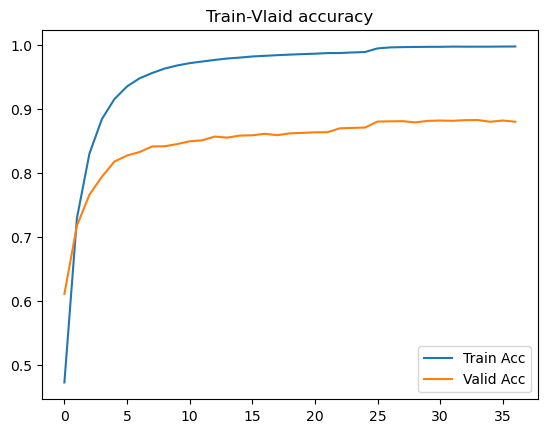

epoch 37 loss: 0.0096:   4%|▌               | 450/11947 [01:52<43:16,  4.43it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 37 loss: 0.0092:  38%|█████▋         | 4525/11947 [18:38<28:14,  4.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 37 loss: 0.0090:  67%|██████████     | 8029/11947 [33:07<15:41,  4.16it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

validation accuracy = 0.88326
[[264   5   1 ...   0   0   0]
 [  6 198   0 ...   0   0   0]
 [  5   2 387 ...   0   0   0]
 ...
 [  0   0   0 ... 175   6   0]
 [  0   0   0 ...  11 206   0]
 [  0   0   0 ...   0   0 221]]


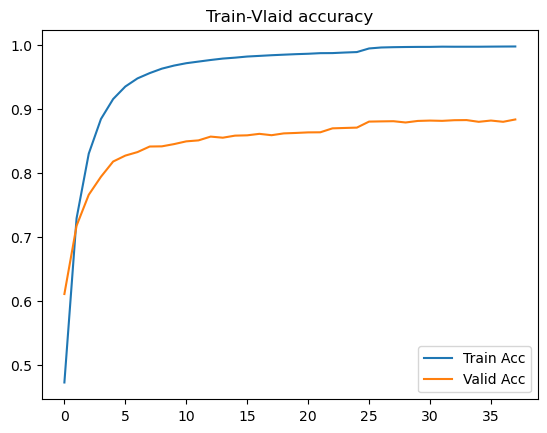

epoch 38 loss: 0.0063:  15%|██▏            | 1789/11947 [07:24<40:11,  4.21it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 38 loss: 0.0088:  45%|██████▊        | 5431/11947 [22:25<25:55,  4.19it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 38 loss: 0.0097:  75%|███████████▎   | 8974/11947 [37:02<11:48,  4.20it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

train accuracy = 0.99712
[[2847    3    1 ...    0    0    0]
 [   4 2849    0 ...    0    0    0]
 [   3    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    3    0]
 [   0    0    0 ...    2 2849    0]
 [   0    0    0 ...    0    0 2852]]


epoch 38 loss: 0.6339:  29%|████▉            | 751/2584 [01:30<03:42,  8.25it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 39 loss: 0.0092:  24%|███▌           | 2828/11947 [11:39<42:59,  3.53it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 39 loss: 0.0088:  54%|████████       | 6401/11947 [26:22<22:51,  4.04it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

In [16]:
%run classification_train_efficientnet2.ipynb

In [18]:
print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
print(train_matrix_list[best_index])
print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
print(valid_matrix_list[best_index])

Best Epoch : 38/ 40
Best Train Accuracy : 0.99712
[[2847    3    1 ...    0    0    0]
 [   4 2849    0 ...    0    0    0]
 [   3    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    3    0]
 [   0    0    0 ...    2 2849    0]
 [   0    0    0 ...    0    0 2852]]
Best Valid Accuracy : 0.88483
[[255  10   2 ...   0   0   0]
 [  6 196   0 ...   0   0   0]
 [  3   0 389 ...   0   0   0]
 ...
 [  0   0   0 ... 178   5   0]
 [  0   0   0 ...  12 208   0]
 [  0   0   0 ...   0   0 218]]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


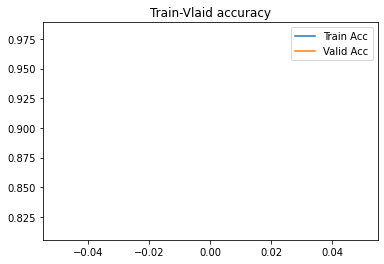

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


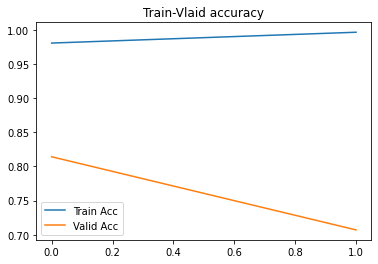

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


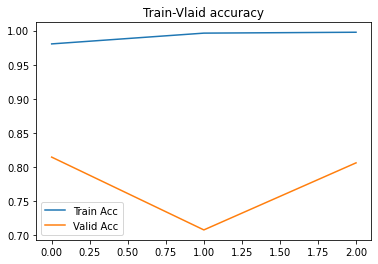

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


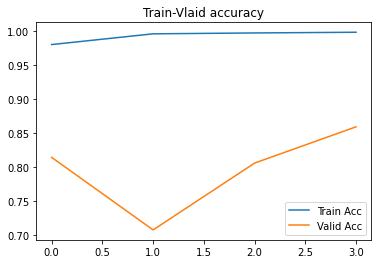

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


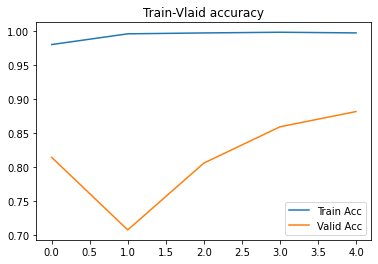

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb